# Comparision of the raijin and gadi piControl experiments

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import datetime, cf_units, cftime, datetime, numpy as np
import cartopy.crs as ccrs
import xarray_tools as xrt
import scipy.signal, scipy.stats
import nc_time_axis


In [3]:
def powerspec(x, fs=1, wfrac=0.1, smooth=11):
    """ Power spectrum, normalised to variance
    wfrac = window smoothing fraction
    smooth = number of pts in Daniell average of periodogram
    """

    # Detrend explicitly first so can get the variance
    tmp = scipy.signal.detrend(x, type='linear')
    f, p = scipy.signal.periodogram(tmp,window=('tukey',wfrac),fs=fs,scaling='density')

    # Scale to match variance
    p[1:] *=  len(tmp)*tmp.var() / p[1:].sum()

    w = np.ones(smooth)
    w[0] = w[-1] = 0.5
    w /= w.sum()
    fs = np.convolve(f[1:],w,mode='valid')
    ps = np.convolve(p[1:],w,mode='valid')

    return fs, ps

In [4]:
def fit_AR_series(series, pmax=5, diag=False):
    """
    Fit an AR series, using BIC to choose the order.
    Based on Katz (1983): Statistical Evaluation of Climate Experiments with General
	       Circulation Models : A Parametric Time Series Modelling Approach,
           J. Atmos. Sci., 39, 1446-1455, DOI 10.1175/1520-0469(1982)039<1446:SEOCEW>2.0.CO;2
    """
    # Array version assumimg time is first dimension.

    n = len(series)
    # Remove mean
    series = series - series.mean(axis=0)

    grid_shp = series.shape[1:]
    # Calculate covariances
    cov = np.zeros((pmax,)+grid_shp, float)
    # The biased forms of the covariances is used because this has smaller
    # variance.
    for lag in range(pmax):
        cov[lag] = np.mean(series[lag:]*series[:n-lag],axis=0)

    if diag:
        print("COV", cov)

    sigsq = np.zeros((pmax,)+grid_shp, float)
    phi = np.zeros((pmax,pmax)+grid_shp, float)

    sigsq[0] = cov[0]
    phi[0,:] = 1.0
    for p in range(1,pmax):
        s = 0.0
        for k in range(p):  # do k=0,p-1
            s = s + phi[k,p-1]*cov[p-k]
        phi[p,p] = -s/sigsq[p-1]
        if diag:
            print("P", p, s, phi[p,p])
        for k in range(1,p):  # do k=1,p-1
            phi[k,p] = phi[k,p-1] + phi[p-k,p-1]*phi[p,p]
        sigsq[p] = ( 1.0 - phi[p,p]*phi[p,p] ) * sigsq[p-1]

    # For each order calculate the information criterion and choose the
    # minimum value as the order of the series.
    bmin = np.full(grid_shp, 1.0e100)
    pmin = np.zeros(grid_shp, np.int32)
    for p in range(pmax):
        sigsq[p] =  sigsq[p] * float(n) / float(n-p-1)
        bic = n*np.log(sigsq[p]) + (p+1)*np.log(float(n))
        aic = n*np.log(sigsq[p]) + 2*(p+1)
        pmin[bic < bmin] = p  # Need to update this before bmin
        bmin[bic < bmin] = bic[bic < bmin]
        if diag:
            print(" P  ",p, "  BIC  ",bic, " AIC ", aic)

    if diag:
        print("bmin", bmin)
        print("pmin", pmin)

    ar = np.zeros((pmax,)+grid_shp, float)
    for p in range(pmax):
        mask = p == pmin
        ar[1:p+1,mask] = -phi[1:p+1,p,mask]

    if diag:
        print("AR", ar)
    return ar

def var_factor(c):
    """ Calculate variance factor from AR series coefficients """
    order = np.argmax((c > 0), axis=0)
    if order.max() > 2:
        raise Exception("Case with max order {0} not handled".format(order.max()))
    # Yule-Walker for AR(2)
    r1 = c[1] / (1-c[2])
    r2 = c[1]*r1 + c[2]
    vfac = (1-c[1]*r1-c[2]*r2)/(1-c[1]-c[2])**2
    return vfac

In [5]:
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

gadi = xr.open_dataset('/g/data/p66/mrd599/access_stats/{0}/{0}.nc'.format('bm135'), decode_times=time_coder)
gadi_ann = xr.open_dataset('/g/data/p66/mrd599/access_stats/{0}/{0}_ann.nc'.format('bm135'), decode_times=time_coder)

# Select the matching period from the longer control runs
raijin = xr.open_dataset('/g/data/p66/mrd599/access_stats/{0}/{0}.nc'.format('bi889'), decode_times=time_coder).sel(time=slice(gadi.time[0], gadi.time[-1]))
raijin_ann = xr.open_dataset('/g/data/p66/mrd599/access_stats/{0}/{0}_ann.nc'.format('bi889'), decode_times=time_coder).sel(time=slice(gadi_ann.time[0], gadi_ann.time[-1]))

# Second 200 year block for comparison
raijin2 = xr.open_dataset('/g/data/p66/mrd599/access_stats/{0}/{0}.nc'.format('bi889'), decode_times=time_coder).sel(time=slice(cftime.DatetimeProlepticGregorian(1150, 1, 16, 12, 0, 0), cftime.DatetimeProlepticGregorian(1349, 12, 16, 12, 0, 0)))
raijin2_ann = xr.open_dataset('/g/data/p66/mrd599/access_stats/{0}/{0}_ann.nc'.format('bi889'), decode_times=time_coder).sel(time=slice(cftime.DatetimeProlepticGregorian(1150, 7, 2, 12, 0, 0), cftime.DatetimeProlepticGregorian(1349, 7, 2, 12, 0, 0)))

In [6]:
area = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/fx/areacella/gn/latest/areacella_fx_ACCESS-CM2_piControl_r1i1p1f1_gn.nc').areacella
area = area.rename({'lat':'latitude', 'lon':'longitude'})

land_area_fraction = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/fx/sftlf/gn/latest/sftlf_fx_ACCESS-CM2_piControl_r1i1p1f1_gn.nc').sftlf
# Convert from percent
land_area_fraction = 0.01*land_area_fraction.rename({'lat':'latitude', 'lon':'longitude'})
ocean_area_fraction =  1 - land_area_fraction

ocean_area = area * ocean_area_fraction

In [7]:
# Time axis is relative to 01-jan-2000
taxis = cf_units.Unit("days since 2000-01-01 00:00", calendar="proleptic_gregorian")
t0 = taxis.date2num(datetime.datetime(950,1,1,0,0,0))
t1 = taxis.date2num(datetime.datetime(1151,1,1,0,0,0))

## Surface air temperature

In [8]:
tas_r = xrt.global_mean(raijin_ann['tas'], area)
tas_r2 = xrt.global_mean(raijin2_ann['tas'], area)
tas_g = xrt.global_mean(gadi_ann['tas'], area)
print(tas_r.mean(dim='time').data, tas_g.mean(dim='time').data)

tmp = scipy.signal.detrend(tas_r)
fit_r = fit_AR_series(tmp,5)
print('AR fit for raijin', fit_r)
vfac_r = var_factor(fit_r)
print("vfac_r", vfac_r)
print()

tmp = scipy.signal.detrend(tas_g)
fit_g = fit_AR_series(tmp,5)
print('AR fit for gadi', fit_g)
vfac_g = var_factor(fit_g)
print("vfac_r", vfac_g)

# For difference of means
vtot = vfac_r*tas_r.var()/len(tas_r) + vfac_g*tas_g.var()/len(tas_g)

print()
print(f"G - R tas mean difference {tas_g.mean(dim='time') - tas_r.mean(dim='time'):.4f}")
print(f"95% CI +/- {2*vtot**0.5:.3f}")

287.0292663574219 287.0331115722656
AR fit for raijin [0.         0.52499939 0.         0.         0.        ]
vfac_r 3.2105209127360554

AR fit for gadi [0.         0.42940829 0.20906402 0.         0.        ]
vfac_r 5.1599887981464

G - R tas mean difference 0.0038
95% CI +/- 0.044


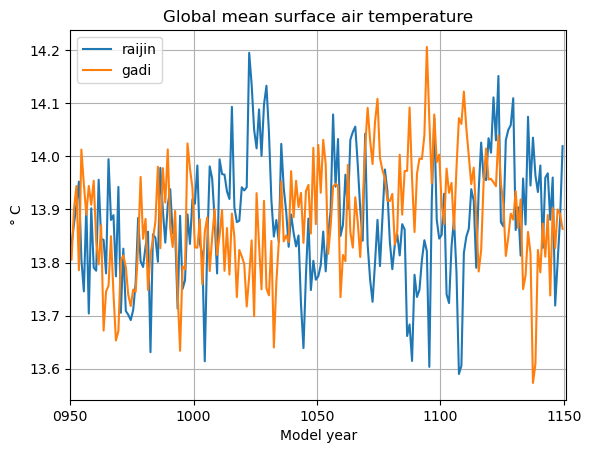

In [9]:
tzero = 273.15
fig, axes = plt.subplots()

(tas_r-tzero).plot(label='raijin')
(tas_g-tzero).plot(label='gadi')

axes.set_title('Global mean surface air temperature')
axes.set_ylabel('$\degree$ C')
axes.set_xlabel('Model year')
year_fmt = nc_time_axis.CFTimeFormatter("%Y", calendar='proleptic_gregorian')
axes.xaxis.set_major_formatter(year_fmt)
axes.set_xlim(t0,t1)
ticks =[taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in range(950,1151,50)]
axes.set_xticks(ticks)
axes.legend()
axes.grid(True)

In [10]:
tmp = scipy.signal.detrend(raijin_ann['tas'][:].data,axis=0)
fit_r = fit_AR_series(tmp,5)
print(fit_r.shape, fit_r.max(), np.unravel_index(fit_r.argmax(), fit_r.shape))
order = np.argmax((fit_r > 0), axis=0)
print(order.max())
vfac_r = var_factor(fit_r)
print("Max vfac_r", vfac_r.max(), np.unravel_index(vfac_r.argmax(), vfac_r.shape))

tmp = scipy.signal.detrend(gadi_ann['tas'][:].data,axis=0)
fit_g = fit_AR_series(tmp,5)
print(fit_g.shape, fit_g.max(), np.unravel_index(fit_g.argmax(), fit_g.shape))
order = np.argmax((fit_g > 0), axis=0)
print(order.max())
vfac_g = var_factor(fit_g)
print("Max vfac_g", vfac_g.max(), np.unravel_index(vfac_g.argmax(), vfac_g.shape))

(5, 144, 192) 0.9402829008811865 (1, 103, 79)
2
Max vfac_r 20.787093910409176 (126, 188)
(5, 144, 192) 1.1758182934775658 (1, 128, 189)
2
Max vfac_g 17.197511780599886 (127, 0)


In [12]:
tr = raijin_ann['tas']
tg = gadi_ann['tas']
n = 200
vr = tr.var(dim='time') * vfac_r * np.exp(2*vfac_r/n) / n
vg = tg.var(dim='time') * vfac_g * np.exp(2*vfac_g/n) / n
vtot = vr + vg
delta = (tg.mean(dim='time') - tr.mean(dim='time')) / vtot**0.5
adelta = abs(delta).values
print(adelta.max(), np.unravel_index(adelta.argmax(), adelta.shape))

# SD for 5 and 1% differences
sig_5pct  = scipy.stats.norm.ppf(0.975)
sig_1pct = scipy.stats.norm.ppf(0.995)
npts = np.prod(adelta.shape)
print(f"Percentage of points with differences significant at 5% = {100*np.sum(adelta > sig_5pct)/npts:.1f}")
print(f"Percentage of points with differences significant at 1% = {100*np.sum(adelta > sig_1pct)/npts:.1f}")

# Area averages of this
s5 = np.where(adelta > sig_5pct, 1, 0)
print(f"Percentage area with differences significant at 5% {(100*s5*area).sum()/area.sum():.1f}")
s1 = np.where(adelta > sig_1pct, 1, 0)
print(f"Percentage area with differences significant at 1% {(100*s1*area).sum()/area.sum():.1f}")


4.153140637387288 (134, 153)
Percentage of points with differences significant at 5% = 7.1
Percentage of points with differences significant at 1% = 2.1
Percentage area with differences significant at 5% 7.8
Percentage area with differences significant at 1% 2.3


Text(0.5, 1.0, '200 year mean temperature difference')

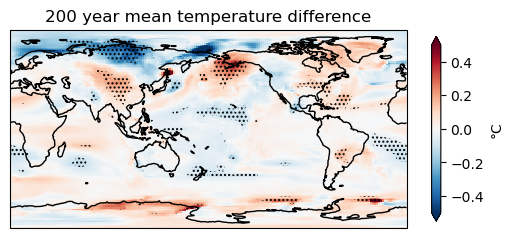

In [13]:
ds = xr.DataArray(adelta, coords=[tr.latitude.values, tr.longitude.values], dims=['latitude', 'longitude'])
tr = raijin_ann['tas'].mean(dim='time')
tg = gadi_ann['tas'].mean(dim='time')

map_proj = ccrs.PlateCarree(central_longitude=180)
p = (tg-tr).plot(vmax=0.5,center=0,subplot_kws={'projection': map_proj},
cbar_kwargs={'label': '°C', 'orientation':'vertical', 'shrink':0.5})

ax = p.axes
# Hatching example https://matplotlib.org/gallery/images_contours_and_fields/contourf_hatching.html
p = ds.plot.contourf(levels=[sig_5pct,100], colors='none', add_colorbar=False, extend='max', hatches=['....'], subplot_kws={'projection': map_proj})
ax.coastlines()
ax.set_title('200 year mean temperature difference')
# savefig('tas_diff_signif.png',dir=savedir,nb=nbname)

Text(0.5, 1.0, 'Distribution of normalised temperature differences')

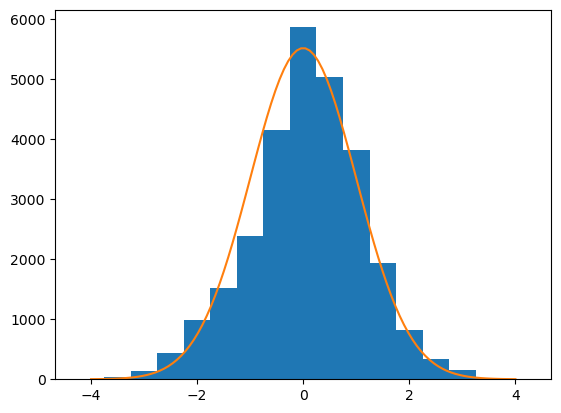

In [14]:
vals = delta.values.ravel()
fig, axes = plt.subplots()
plt.hist(vals,bins=np.linspace(-4.25,4.25,18))
x = np.linspace(-4, 4, 100)
# Factor 0.5 to normalise to bin width
plt.plot(x, 0.5*192*144*scipy.stats.norm.pdf(x, 0, 1))
ax.set_title('Distribution of normalised temperature differences')

## Precipitation

In [15]:
pr_r = xrt.global_mean(raijin_ann['pr'], area)*86400
pr_g = xrt.global_mean(gadi_ann['pr'], area)*86400
print(pr_r.mean(dim='time').data, pr_g.mean(dim='time').data)
tmp = scipy.signal.detrend(pr_r)
fit_r = fit_AR_series(tmp,5)
print('AR fit for raijin', fit_r)
vfac_r = var_factor(fit_r)
print("vfac_r", vfac_r)
print()

tmp = scipy.signal.detrend(pr_g)
fit_g = fit_AR_series(tmp,5)
print('AR fit for gadi', fit_g)
vfac_g = var_factor(fit_g)
print("vfac_r", vfac_g)

# For difference of means
vtot = vfac_r*pr_r.var()/len(pr_r) + vfac_g*pr_g.var()/len(pr_g)

print()
print(f"G-R precip difference {pr_g.mean(dim='time') - pr_r.mean(dim='time'):.4f}")
print(f"95% CI +/- {2*vtot**0.5:.3f}")

3.135005035903305 3.135635968472343
AR fit for raijin [0.         0.32387904 0.         0.         0.        ]
vfac_r 1.958050604489476

AR fit for gadi [0.         0.06638528 0.3088881  0.         0.        ]
vfac_r 2.2963874192238296

G-R precip difference 0.0006
95% CI +/- 0.003


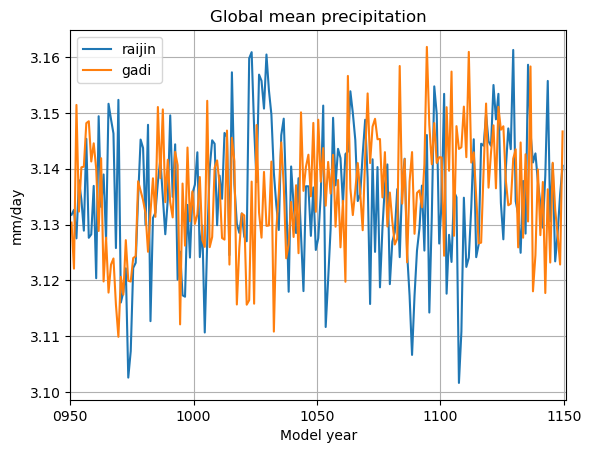

In [16]:
fig, axes = plt.subplots()

pr_r.plot(label='raijin')
pr_g.plot(label='gadi')

axes.set_title('Global mean precipitation')
axes.set_ylabel('mm/day')
axes.set_xlabel('Model year')
axes.set_xlim(t0,t1)
axes.xaxis.set_major_formatter(year_fmt)
ticks =[taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in range(950,1151,50)]
axes.set_xticks(ticks)
axes.legend()
axes.grid(True)

In [17]:
tmp = scipy.signal.detrend(raijin_ann['pr'][:].data,axis=0)*86400
fit_r = fit_AR_series(tmp,5)
print(fit_r.shape, fit_r.max(), np.unravel_index(fit_r.argmax(), fit_r.shape))
order = np.argmax((fit_r > 0), axis=0)
print(order.max())
vfac_r = var_factor(fit_r)
print("Max vfac_r", vfac_r.max(), np.unravel_index(vfac_r.argmax(), vfac_r.shape))

tmp = scipy.signal.detrend(gadi_ann['pr'][:].data,axis=0)*86400
fit_g = fit_AR_series(tmp,5)
print(fit_g.shape, fit_g.max(), np.unravel_index(fit_g.argmax(), fit_g.shape))
order = np.argmax((fit_g > 0), axis=0)
print(order.max())
vfac_g = var_factor(fit_g)
print("Max vfac_g", vfac_g.max(), np.unravel_index(vfac_g.argmax(), vfac_g.shape))

(5, 144, 192) 0.6489759730799722 (1, 133, 20)
2
Max vfac_r 5.334308607980803 (134, 19)
(5, 144, 192) 0.5295423677648934 (1, 97, 169)
2
Max vfac_g 4.557467322165429 (96, 168)


In [18]:
pr = raijin_ann['pr'] * 86400
pg = gadi_ann['pr'] * 86400
n = 200
vr = pr.var(dim='time') * vfac_r * np.exp(2*vfac_r/n) / n
vg = pg.var(dim='time') * vfac_g * np.exp(2*vfac_g/n) / n
vtot = vr + vg
delta = (pg.mean(dim='time') -pr.mean(dim='time')) / vtot**0.5
adelta = abs(delta).values
print(adelta.max(), np.unravel_index(adelta.argmax(), adelta.shape))

4.0422913185838745 (111, 173)


Percentage of points with differences significant at 5% = 4.7
Percentage of points with differences significant at 1% = 1.0
Percentage area with differences significant at 5% 5.6
Percentage area with differences significant at 1% 1.2


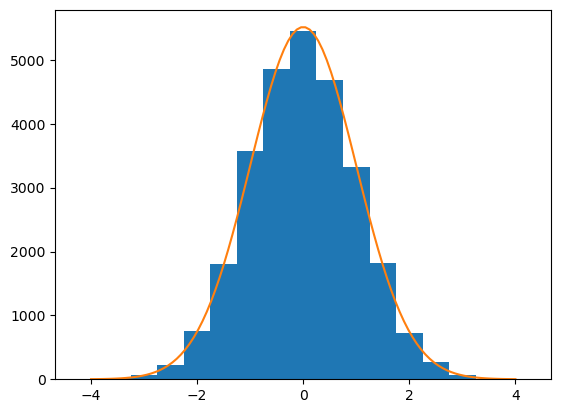

In [19]:
vals = delta.values.ravel()
fig, axes = plt.subplots()
plt.hist(vals,bins=np.linspace(-4.25,4.25,18))
x = np.linspace(-4, 4, 100)
# Factor 0.5 to normalise to bin width
plt.plot(x, 0.5*192*144*scipy.stats.norm.pdf(x, 0, 1))
ax.set_title('Distribution of normalised  differences')

print(f"Percentage of points with differences significant at 5% = {100*np.sum(adelta > sig_5pct)/npts:.1f}")
print(f"Percentage of points with differences significant at 1% = {100*np.sum(adelta > sig_1pct)/npts:.1f}")

# Area averages of this
s5 = np.where(adelta > sig_5pct, 1, 0)
print(f"Percentage area with differences significant at 5% {(100*s5*area).sum()/area.sum():.1f}")
s1 = np.where(adelta > sig_1pct, 1, 0)
print(f"Percentage area with differences significant at 1% {(100*s1*area).sum()/area.sum():.1f}")

Text(0.5, 1.0, '200 year mean precipitation difference')

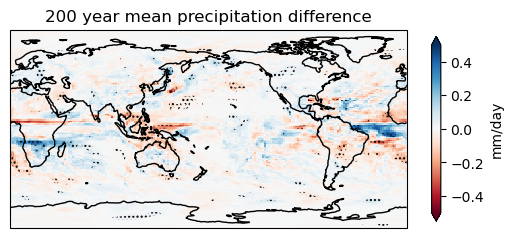

In [20]:
pr = raijin_ann['pr'].mean(dim='time')*86400
pg = gadi_ann['pr'].mean(dim='time')*86400
ds = xr.DataArray(adelta, coords=[pr.latitude.values, pr.longitude.values], dims=['latitude', 'longitude'])

map_proj = ccrs.PlateCarree(central_longitude=180)
p = (pg-pr).plot(vmax=0.5,center=0,cmap='RdBu',subplot_kws={'projection': map_proj},
cbar_kwargs={'label': 'mm/day', 'orientation':'vertical', 'shrink':0.5})

ax = p.axes
# Hatching example https://matplotlib.org/gallery/images_contours_and_fields/contourf_hatching.html
p = ds.plot.contourf(levels=[sig_5pct,100], colors='none', add_colorbar=False, extend='max', hatches=['....'], subplot_kws={'projection': map_proj})
ax.coastlines()
ax.set_title('200 year mean precipitation difference')

## TOA net energy balance

In [21]:
rlut_r = xrt.global_mean(raijin_ann['rlut'], area)
rlut_g = xrt.global_mean(gadi_ann['rlut'], area)
rsdt_r = xrt.global_mean(raijin_ann['rsdt'], area)
rsdt_g = xrt.global_mean(gadi_ann['rsdt'], area)
rsut_r = xrt.global_mean(raijin_ann['rsut'], area)
rsut_g = xrt.global_mean(gadi_ann['rsut'], area)
net_r = rsdt_r - rsut_r - rlut_r
net_g = rsdt_g - rsut_g - rlut_g
print(net_r.mean(dim='time').data, net_g.mean(dim='time').data)

0.3969743251800537 0.39775145053863525


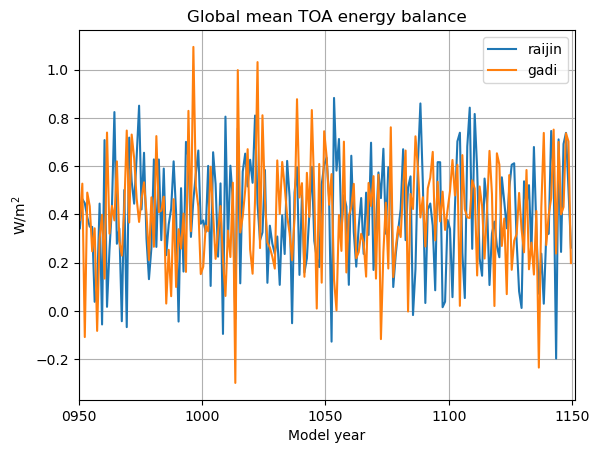

In [22]:
fig, axes = plt.subplots()

net_r.plot(label='raijin')
net_g.plot(label='gadi')

axes.set_title('Global mean TOA energy balance')
axes.set_ylabel('W/m$^2$')
axes.set_xlabel('Model year')
axes.set_xlim(t0,t1)
axes.xaxis.set_major_formatter(year_fmt)
ticks =[taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in range(950,1151,50)]
axes.set_xticks(ticks)
axes.legend()
axes.grid(True)

## SST

In [23]:
tsea_r = xrt.global_mean(raijin_ann['ts_sea'], ocean_area) - 273.15
tsea_g = xrt.global_mean(gadi_ann['ts_sea'], ocean_area) - 273.15
print(tsea_g.mean() - tsea_r.mean())

<xarray.DataArray 'ts_sea' ()> Size: 8B
array(0.00130463)
Coordinates:
    height   float64 8B 1.5


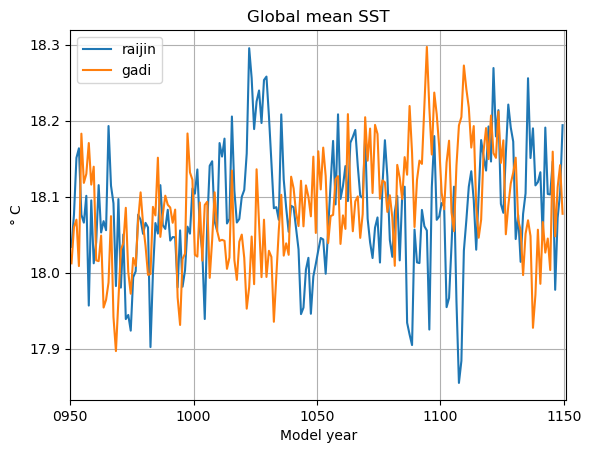

In [24]:
fig, axes = plt.subplots()

tsea_r.plot(label='raijin')
tsea_g.plot(label='gadi')

axes.set_title('Global mean SST')
axes.set_ylabel('$\degree$ C')
axes.set_xlabel('Model year')
axes.xaxis.set_major_formatter(year_fmt)
axes.set_xlim(t0,t1)
ticks =[taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in range(950,1151,50)]
axes.set_xticks(ticks)
axes.legend()
axes.grid(True)
# savefig('sst_gmean_compare.png',dir=savedir,nb=nbname)

In [25]:
#  RMS difference of annual means
tas_rms = xrt.rms_diff(raijin_ann['tas'],gadi_ann['tas'],area)
tsea_rms = xrt.rms_diff(raijin_ann['ts_sea'],gadi_ann['ts_sea'],ocean_area)

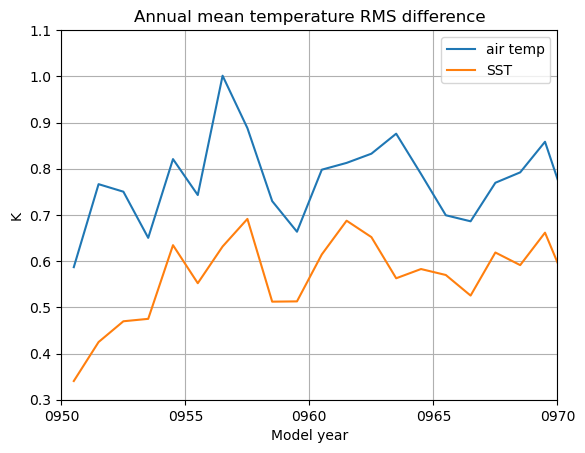

In [26]:
fig, axes = plt.subplots()
tas_rms.plot(label='air temp')
tsea_rms.plot(label='SST')
axes.set_title('Annual mean temperature RMS difference')
axes.set_ylabel('K')
axes.set_xlabel('Model year')
t2 = taxis.date2num(datetime.datetime(970,1,1,0,0,0))
axes.set_xlim(t0,t2)
axes.xaxis.set_major_formatter(year_fmt)
ticks =[taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in range(950,971,5)]
axes.set_xticks(ticks)
axes.set_ylim(0.3,1.1)
axes.legend()
axes.grid(True)

## Nino 34

In [27]:
tmp = raijin['ts_sea'].sel(latitude=slice(-5,5),longitude=slice(190,240))
ts_n34 = tmp.mean(['latitude','longitude'])
n34_r = ts_n34.groupby('time.month') - xrt.annual_cycle(ts_n34)
n34_r.load()
tmp = raijin2['ts_sea'].sel(latitude=slice(-5,5),longitude=slice(190,240))
ts_n34 = tmp.mean(['latitude','longitude'])
n34_r2 = ts_n34.groupby('time.month') - xrt.annual_cycle(ts_n34)
n34_r2.load()
tmp = gadi['ts_sea'].sel(latitude=slice(-5,5),longitude=slice(190,240))
ts_n34 = tmp.mean(['latitude','longitude'])
n34_g = ts_n34.groupby('time.month') - xrt.annual_cycle(ts_n34)
n34_g.load()

<xarray.DataArray (time: 2400)> Size: 19kB
array([ 0.03375137,  0.02444268, -0.10711151, ..., -1.05233398,
       -1.00711121, -1.07842194])
Coordinates:
  * time     (time) object 19kB 0950-01-16 12:00:00 ... 1149-12-16 12:00:00
    height   float64 8B 1.5
    month    (time) int64 19kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

0.8837107150281514 0.7903754936046491 0.8855412386998442


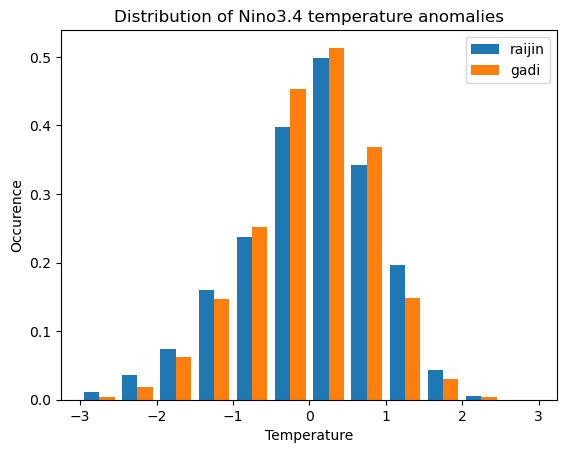

In [28]:
fig, axes = plt.subplots()
# plt.hist([n34_r.data, n34_g.data, n34_r2.data], bins=np.linspace(-3,3,11))
plt.hist([n34_r.data, n34_g.data], bins=np.linspace(-3,3,13), density=True, label=['raijin', 'gadi'])
print(n34_r.data.std(), n34_g.data.std(), n34_r2.data.std())
axes.set_title('Distribution of Nino3.4 temperature anomalies')
axes.set_xlabel('Temperature')
axes.set_ylabel('Occurence')
axes.legend()
# savefig('nino34_histogram.png',dir=savedir,nb=nbname)

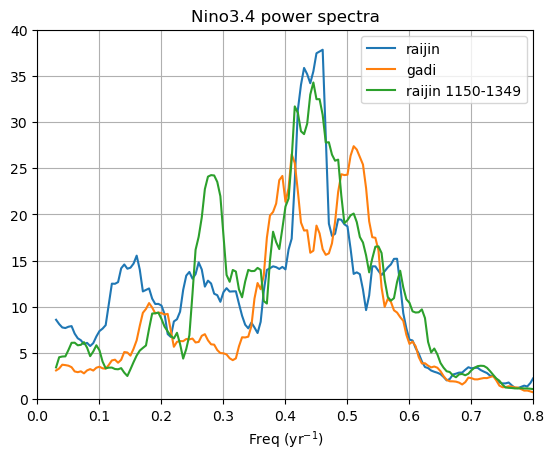

In [29]:
smooth=11
fig, axes = plt.subplots()
f, p = powerspec(n34_r.data,fs=12, smooth=smooth)
plt.plot(f,p,label='raijin')
f, p = powerspec(n34_g.data,fs=12, smooth=smooth)
plt.plot(f,p,label='gadi')
f, p = powerspec(n34_r2.data,fs=12, smooth=smooth)
plt.plot(f,p,label='raijin 1150-1349')
axes.set_xlim(0,0.8)
axes.set_ylim(0,40)
axes.set_xlabel('Freq (yr$^{-1}$)')
axes.grid(True)
axes.set_title('Nino3.4 power spectra')
axes.legend()